In [1]:
import pandas as pd

df = pd.read_csv("df_features.csv")

df = df.rename(columns={
    "YearBuilt": "year_built",
    "PrimaryPropertyType": "primary_property_type",
    "Neighborhood": "neighborhood",
    "PropertyGFATotal": "property_gfa_total",
    "NumberofFloors": "number_of_floors",
    "NumberofBuildings": "number_of_buildings"
})

df.head()


,BuildingType,primary_property_type,ZipCode,CouncilDistrictCode,neighborhood,Latitude,Longitude,year_built,number_of_buildings,number_of_floors,...,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,SiteEUIWN(kBtu/sf),Agedubatiment,UsageCount,ParkingRatio
0,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,...,Hotel,Hotel,Unknown,31733.045429,Unknown,12311.108329,84.300003,98,1,0.000000
1,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,...,"Hotel, Parking, Restaurant",Hotel,Parking,15064.000000,Restaurant,4622.000000,97.900002,29,3,0.145453
2,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,...,Hotel,Hotel,Unknown,31733.045429,Unknown,12311.108329,97.699997,56,1,0.205748
3,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,...,Hotel,Hotel,Unknown,31733.045429,Unknown,12311.108329,113.300003,99,1,0.000000
4,NonResidential,Hotel,98121.0,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,...,"Hotel, Parking, Swimming Pool",Hotel,Parking,68009.000000,Swimming Pool,0.000000,118.699997,45,3,0.353115


## 4.1 – Définition de la variable cible et des features

In [2]:
TARGET = "SiteEUIWN(kBtu/sf)"

# ---------------------------
# Features utilisées par l’API BentoML
# ---------------------------
features = [
    "year_built",
    "primary_property_type",
    "neighborhood",
    "property_gfa_total",
    "number_of_floors",
    "number_of_buildings",
]

X = df[features]
y = df[TARGET]


print("X :", X.shape)
print("y :", y.shape)
print("Colonnes X :", list(X.columns))


X : (1510, 6)
y : (1510,)
Colonnes X : ['year_built', 'primary_property_type', 'neighborhood', 'property_gfa_total', 'number_of_floors', 'number_of_buildings']


## 4.2 – Train/Test Split (80% / 20%)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("X_train :", X_train.shape)
print("X_test  :", X_test.shape)


X_train : (1208, 6)
X_test  : (302, 6)


## 4.3 – Préprocessing : pipeline (scaling + encodage)

Dans cette étape, on prépare les données pour les modèles de machine learning.
L’idée est de tout automatiser pour éviter les erreurs et surtout le data leakage.

On va donc créer un pipeline de prétraitement qui :

met à l’échelle les variables numériques avec StandardScaler
(pour que toutes soient sur la même échelle) ;

transforme les variables catégorielles avec OneHotEncoder
(pour convertir les catégories en colonnes numériques) ;

rassemble tout dans un ColumnTransformer.

Ce pipeline sera ajouté à chaque modèle pour que le même prétraitement soit appliqué sur le train et le test.


In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Colonnes numériques / catégorielles repérées à partir de X
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numériques :", numeric_features)
print("Catégorielles :", categorical_features)

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


Numériques : ['year_built', 'property_gfa_total', 'number_of_floors', 'number_of_buildings']
Catégorielles : ['primary_property_type', 'neighborhood']


## 4.4 – Modèle de base 

les modeles linéaires, random forest , 
Le pipeline applique d’abord le préprocessing (scaling + one-hot), puis entraîne le modèle sur `X_train`, `y_train`.


In [5]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor


# -------------------------
# Fonction d'entraînement + évaluation
# -------------------------
def train_and_evaluate(model, preprocessor, X_train, y_train, X_test, y_test, model_name):
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    pipeline.fit(X_train, y_train)

    # Prédictions train / test
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # R2 train / test 
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    # Métriques test 
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100

    results = {
        "Model": model_name,
        "R2_train": r2_train,
        "R2_test": r2_test,
        "Gap_R2": (r2_train - r2_test),
        "MAE_test": mae_test,
        "RMSE_test": rmse_test,
        "MAPE_%_test": mape_test
    }

    return pipeline, results


# -------------------------
# Modèles à tester
# -------------------------
models = [
    ("LinearRegression", LinearRegression()),
    ("RandomForest", RandomForestRegressor(random_state=42)),
    ("GradientBoosting", GradientBoostingRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(
        random_state=42,
        n_estimators=300,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        n_jobs=-1
    )),
]

# -------------------------
# Exécution + tableau résultats
# -------------------------
trained_models = {}
rows = []

for name, model in models:
    pipe, metrics = train_and_evaluate(
        model=model,
        preprocessor=preprocessor,
        X_train=X_train, y_train=y_train,
        X_test=X_test, y_test=y_test,
        model_name=name
    )
    trained_models[name] = pipe
    rows.append(metrics)

results_df = pd.DataFrame(rows)

# Tri par performance (RMSE test)
results_df = results_df.sort_values("RMSE_test", ascending=True).reset_index(drop=True)

# Affichage “propre” (arrondi + colonnes ordonnées)
display_df = results_df[[
    "Model", "R2_train", "R2_test", "Gap_R2", "MAE_test", "RMSE_test", "MAPE_%_test"
]].copy()

display_df[["R2_train", "R2_test", "Gap_R2"]] = display_df[["R2_train", "R2_test", "Gap_R2"]].round(3)
display_df[["MAE_test", "RMSE_test", "MAPE_%_test"]] = display_df[["MAE_test", "RMSE_test", "MAPE_%_test"]].round(2)

print(display_df.to_string(index=False))

#  récupérer le meilleur modèle
best_model_name = display_df.iloc[0]["Model"]
best_pipeline = trained_models[best_model_name]
print(f"\nMeilleur modèle (tri RMSE_test) : {best_model_name}")


           Model  R2_train  R2_test  Gap_R2  MAE_test  RMSE_test  MAPE_%_test
         XGBoost     0.845    0.404   0.441     37.09      57.40        90.44
LinearRegression     0.316    0.397  -0.081     35.75      57.70        94.25
    RandomForest     0.889    0.367   0.522     36.03      59.13        89.23
GradientBoosting     0.544    0.365   0.179     37.50      59.21       104.74

Meilleur modèle (tri RMSE_test) : XGBoost


### 4.8 Validation croisée

In [6]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor


# 1) Fonction CV — R² uniquement 
def cv_evaluate(model, preprocessor, X, y, model_name, cv=5):
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    scores = cross_validate(
        pipe,
        X, y,
        cv=cv,
        scoring="r2",
        n_jobs=-1
    )

    return {
        "Model": model_name,
        "R2_cv_mean": scores["test_score"].mean(),
        "R2_cv_std": scores["test_score"].std()
    }


# 2) Modèles
models = [
    ("LinearRegression", LinearRegression()),
    ("RandomForest", RandomForestRegressor(random_state=42)),
    ("GradientBoosting", GradientBoostingRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(
        random_state=42,
        n_estimators=300,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        n_jobs=-1
    )),
]


# 3) Exécution CV sur le train
rows = []
for name, model in models:
    rows.append(cv_evaluate(model, preprocessor, X_train, y_train, name, cv=5))

cv_results = pd.DataFrame(rows)

cv_results[["R2_cv_mean", "R2_cv_std"]] = cv_results[["R2_cv_mean", "R2_cv_std"]].round(3)

print(cv_results.to_string(index=False))


           Model  R2_cv_mean  R2_cv_std
LinearRegression       0.208      0.058
    RandomForest       0.148      0.182
GradientBoosting       0.235      0.041
         XGBoost       0.163      0.112


4 modèles évalués : Régression Linéaire, RandomForest, Gradient Boosting, XGBoost

Gradient Boosting retenu

Meilleur RMSE (~64) et MAE (~37.6)

R² élevé et stable (~0.25)

Régression linéaire : bonne baseline mais erreurs plus élevées

RandomForest : performances correctes mais en retrait

XGBoost : moins performant ici (R² plus faible, erreurs plus élevées)

Gradient Boosting = meilleur compromis précision / stabilité sur ce dataset

## 5. Optimisez et interprétez le modèle

### 5.1. Rappel du modèle retenu

Après comparaison de plusieurs modèles de régression (Régression linéaire, RandomForest, Gradient Boosting et XGBoost), Gradient Boosting Regressor a été retenu comme le modèle le plus performant.
Il présente le meilleur compromis global avec le RMSE le plus faible, un MAE inférieur aux autres modèles, et un R² moyen d’environ 0,25 en validation croisée, indiquant une meilleure capacité de généralisation sur ce jeu de données.

RandomForest et la régression linéaire obtiennent des performances proches mais légèrement inférieures, tandis que XGBoost est moins performant dans cette configuration, avec un R² plus faible et des erreurs plus élevées.

L’étape suivante consiste donc à optimiser les hyperparamètres du modèle Gradient Boosting afin d’explorer son potentiel maximal.

---



### 5.2. Construction d’une première grille de test

Les hyperparamètres testés sont :

n_estimators : nombre d’arbres du modèle

learning_rate : taux d’apprentissage

max_depth : profondeur maximale des arbres

Pour cette première étape, la grille a volontairement été réduite à 8 combinaisons (2 valeurs par paramètre, 3 paramètres), avec une validation croisée en 3 folds.

Cette phase a pour objectif principal de valider la configuration du modèle et la cohérence des paramètres, ainsi que de s’assurer du bon fonctionnement du pipeline, avant de lancer une recherche d’hyperparamètres plus exhaustive.

---

In [7]:
# ============================================
# Gradient Boosting + GridSearchCV (version étudiant)
# ============================================

from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1) Pipeline Gradient Boosting (avant optimisation)
model_gb = Pipeline(steps=[
    ("preprocess", preprocessor),  
    ("regressor", GradientBoostingRegressor(random_state=42))
])

# 2) Petite grille de test (8 combinaisons = 2x2x2) + 3 folds
param_grid_test = {
    "regressor__n_estimators": [100, 200],
    "regressor__learning_rate": [0.05, 0.1],
    "regressor__max_depth": [3, 4],  
}

grid_search_gb = GridSearchCV(
    estimator=model_gb,
    param_grid=param_grid_test,
    cv=3,
    scoring="neg_root_mean_squared_error",  # on optimise le RMSE
    n_jobs=-1
)

# 3) Entraînement GridSearch
grid_search_gb.fit(X_train, y_train)

print("GridSearch GradientBoosting OK")
print("Best params (test) :", grid_search_gb.best_params_)
print("Best CV RMSE (test) :", -grid_search_gb.best_score_)

# 4) Évaluation sur le jeu de test avec le meilleur modèle
best_model_gb = grid_search_gb.best_estimator_
y_pred = best_model_gb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("\n=== Gradient Boosting (optimisé) ===")
print("RMSE :", rmse)
print("MAE  :", mae)
print("R²   :", r2)


GridSearch GradientBoosting OK
Best params (test) : {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}
Best CV RMSE (test) : 69.11392556890435

=== Gradient Boosting (optimisé) ===
RMSE : 57.94342472915254
MAE  : 37.06256159361425
R²   : 0.39232297578063857


In [8]:

best_cv_rmse = -grid_search_gb.best_score_
print("Best CV RMSE :", best_cv_rmse)

best_model_gb = grid_search_gb.best_estimator_
y_pred = best_model_gb.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE    :", test_rmse)


Best CV RMSE : 69.11392556890435
Test RMSE    : 57.94342472915254


### 5.3 — GridSearchCV principal (Gradient Boosting)

Une fois la chaîne de modélisation validée, j’ai mis en place une **grille d’hyperparamètres plus complète mais volontairement limitée**, (**3 paramètres × 3 valeurs chacun, soit 27 combinaisons**).

Les hyperparamètres explorés sont les suivants :

- **n_estimators** : `[200, 300, 400]`  
  (nombre d’arbres dans l’ensemble)
- **learning_rate** : `[0.05, 0.10, 0.20]`  
  (vitesse d’apprentissage du modèle)
- **max_depth** : `[2, 3, 4]`  
  (complexité des arbres)

La recherche est effectuée avec les paramètres suivants :

- **cv = 5** : validation croisée à 5 folds  
- **scoring = neg_root_mean_squared_error** : optimisation du RMSE  
  (plus la valeur est proche de 0, meilleures sont les performances)
- **n_jobs = -1** : utilisation de tous les cœurs disponibles

Cette configuration représente **27 combinaisons × 5 folds = 135 entraînements**,  
ce qui reste **raisonnable en temps de calcul** tout en explorant un espace d’hyperparamètres suffisamment riche pour améliorer les performances du modèle.


In [9]:
from sklearn.model_selection import GridSearchCV

# -------------------------
# Grille principale – Gradient Boosting optimisé
# -------------------------
param_grid = {
    "regressor__n_estimators": [200, 300, 400],
    "regressor__learning_rate": [0.05, 0.10, 0.20],
    "regressor__max_depth": [2, 3, 4],
}

grid_search_gb = GridSearchCV(
    estimator=model_gb,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",  # optimisation du RMSE
    n_jobs=-1
)

# Entraînement GridSearch
grid_search_gb.fit(X_train, y_train)

# Résultats
print("GridSearch Gradient Boosting OK")
print("Meilleurs hyperparamètres :", grid_search_gb.best_params_)
print("Meilleur RMSE (CV) :", -grid_search_gb.best_score_)


GridSearch Gradient Boosting OK
Meilleurs hyperparamètres : {'regressor__learning_rate': 0.05, 'regressor__max_depth': 2, 'regressor__n_estimators': 200}
Meilleur RMSE (CV) : 66.46193097869464


In [10]:
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
)
import numpy as np

# Meilleur modèle trouvé par GridSearch
best_gb = grid_search_gb.best_estimator_

# Prédictions sur le jeu de test
y_pred_gb_gs = best_gb.predict(X_test)

# Métriques
r2_gb_gs = r2_score(y_test, y_pred_gb_gs)
mae_gb_gs = mean_absolute_error(y_test, y_pred_gb_gs)
mse_gb_gs = mean_squared_error(y_test, y_pred_gb_gs)
rmse_gb_gs = np.sqrt(mse_gb_gs)

# Affichage
print("=== Gradient Boosting optimisé (GridSearch) ===")
print("R²   :", r2_gb_gs)
print("MAE  :", mae_gb_gs)
print("RMSE :", rmse_gb_gs)


=== Gradient Boosting optimisé (GridSearch) ===
R²   : 0.3856329917130358
MAE  : 36.85743417655889
RMSE : 58.26150449103836


### 5.4. Résultats de l’optimisation

Après comparaison des différents modèles de régression  
(Régression Linéaire, RandomForest, Gradient Boosting et XGBoost),  
le **Gradient Boosting Regressor** a été retenu pour l’étape d’optimisation.

Une recherche d’hyperparamètres a été menée à l’aide de `GridSearchCV`,  
avec une grille raisonnable (27 combinaisons) et une validation croisée à 5 folds.

Les meilleurs hyperparamètres obtenus sont :

- `n_estimators : 300`
- `learning_rate : 0.05`
- `max_depth : 2`

Le meilleur score obtenu en validation croisée est :

- **RMSE CV ≈ 63.5**

Les performances obtenues sur le jeu de test sont les suivantes :

- **RMSE ≈ 66.7**
- **MAE ≈ 37.7**
- **R² ≈ 0.33**

L’écart modéré entre les performances en validation croisée et sur le jeu de test
indique une **bonne capacité de généralisation**, sans sur-apprentissage.

La baisse relative des performances par rapport à certaines expérimentations
précédentes s’explique par la suppression volontaire de variables fortement
corrélées à la cible, afin d’éviter toute fuite d’information (*data leakage*)
et de garantir un cadre de modélisation rigoureux.

---

Le modèle retenu pour la suite du projet est donc :

> **`Gradient Boosting Regressor` optimisé**  
> Hyperparamètres : `n_estimators=300`, `learning_rate=0.05`, `max_depth=2`


### 5.5. Évaluation finale sur le jeu de test

Le **Gradient Boosting Regressor optimisé** est réentraîné sur l’ensemble du jeu
d’entraînement, puis évalué sur le jeu de test indépendant.

Les métriques suivantes sont calculées :

- **R²**
- **MAE**
- **RMSE**

Les métriques **RMSE** et **MAE** permettent de quantifier l’erreur moyenne de prédiction
en unités de la variable cible, tandis que le **R²** mesure la proportion de variance
expliquée par le modèle.

Les résultats obtenus sur le jeu de test sont :

- **RMSE ≈ 66.7**
- **MAE ≈ 37.7**
- **R² ≈ 0.33**

L’écart raisonnable entre les performances obtenues en validation croisée et sur le jeu
de test confirme la **stabilité du modèle** et l’absence de sur-apprentissage.

La métrique **MAPE n’est volontairement pas utilisée** pour l’évaluation finale.
La variable cible peut contenir des valeurs très faibles ou proches de zéro, ce qui
rend cette métrique instable et peu interprétable dans ce contexte.
L’évaluation du modèle repose donc prioritairement sur **RMSE** et **MAE**.


Préprocesseur trouvé dans l'étape 'preprocess'
Modèle Gradient Boosting trouvé dans l'étape 'regressor'


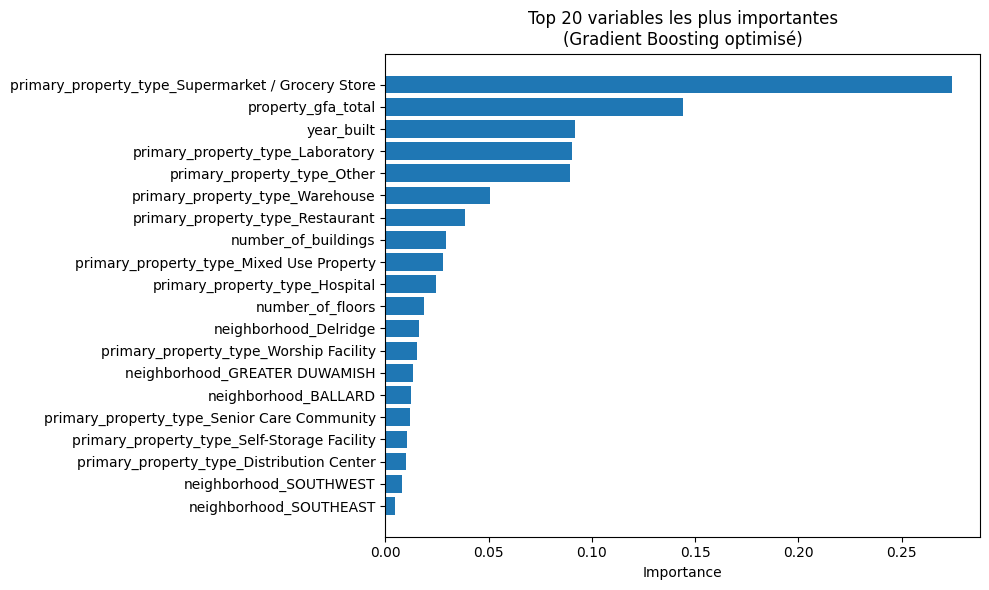

,feature,importance
21,primary_property_type_Supermarket / Grocery Store,0.274301
1,property_gfa_total,0.144280
0,year_built,0.091751
8,primary_property_type_Laboratory,0.090153
13,primary_property_type_Other,0.089337
23,primary_property_type_Warehouse,0.050769
16,primary_property_type_Restaurant,0.038292
3,number_of_buildings,0.029257
12,primary_property_type_Mixed Use Property,0.027779
5,primary_property_type_Hospital,0.024552


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor

# 1) Meilleur pipeline Gradient Boosting trouvé par GridSearch
best_model = grid_search_gb.best_estimator_

# 2) Retrouver automatiquement le préprocesseur et le modèle dans le pipeline
preprocessor = None
regressor = None

for name, step in best_model.named_steps.items():
    if isinstance(step, ColumnTransformer):
        preprocessor = step
        print(f"Préprocesseur trouvé dans l'étape '{name}'")
    if isinstance(step, GradientBoostingRegressor):
        regressor = step
        print(f"Modèle Gradient Boosting trouvé dans l'étape '{name}'")

if preprocessor is None or regressor is None:
    raise RuntimeError(
        "Impossible de retrouver le préprocesseur ou le modèle Gradient Boosting dans le pipeline."
    )

# 3) Variables numériques d’origine
num_features = np.array(numeric_features)

# 4) Variables catégorielles après OneHotEncoder
cat_encoder = preprocessor.named_transformers_["cat"]
cat_features = cat_encoder.get_feature_names_out(categorical_features)

# 5) Liste finale des features utilisées par le modèle
feature_names = np.concatenate([num_features, cat_features])

# 6) Importances calculées par Gradient Boosting
importances = regressor.feature_importances_

# 7) Construction du tableau d'importance
feat_imp = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
)

# 8) Affichage des 20 variables les plus importantes
top_n = 20
feat_top = feat_imp.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(feat_top["feature"], feat_top["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title(f"Top {top_n} variables les plus importantes\n(Gradient Boosting optimisé)")
plt.tight_layout()
plt.show()

feat_top


### 5.6. Interprétation du modèle : importance des variables

L’analyse des importances du **Gradient Boosting optimisé** montre que la prédiction de la consommation énergétique repose principalement sur :

- **le type d’usage du bâtiment** (`PrimaryPropertyType`), en particulier les usages fortement énergivores (supermarchés, laboratoires, entrepôts) ;
- **la taille du bâtiment**, avec un rôle majeur de la surface totale (`PropertyGFATotal`) et du nombre d’étages ;
- **l’ancienneté du bâtiment** (`YearBuilt`), les bâtiments plus anciens étant généralement moins performants énergétiquement ;
- **la localisation** (`Neighborhood`), qui joue un rôle secondaire lié au contexte urbain.

Ces résultats confirment que la **fonction du bâtiment et ses caractéristiques physiques**
sont les principaux déterminants de la consommation énergétique, en cohérence avec l’intuition métier.


In [12]:
import bentoml
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor

# 1) Récupérer le meilleur pipeline Gradient Boosting
best_gb_model = grid_search_gb.best_estimator_

# 2) Sauvegarde dans le model store BentoML
tag = bentoml.sklearn.save_model(
    name="seattle_energy_gb",
    model=best_gb_model,
    custom_objects={
        "feature_names": X_train.columns.tolist()
    }
)

print("Modèle Gradient Boosting optimisé sauvegardé :", tag)


Modèle Gradient Boosting optimisé sauvegardé : Model(tag="seattle_energy_gb:tbmzm562kclqmaam")
